<a href="https://colab.research.google.com/github/Rogerio-mack/Temporal/blob/main/cap5_SarimaX_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelos ARIMA Sazonais e com Variáveis Exógenas** 
___


Neste capítulo você vai aprender sobre:

* Ajustar modelos ARIMA para dados com efeitos de sazonalidade
* Levar em conta o efeito de variáveis exógenas 

## Modelos SARIMA

Nos capítulos anteriores você aprendeu como modelar séries temporais através dos modelos ARIMA. A classe de modelos ARIMA assume entre outras premissas básicas que a série temporal estudada é estacionária, livre de tendência e sazonalidade. A estacionariedade de uma série pode ser verificada a partir do teste de Dickey Fuller, equanto que o efeito de sazonalidade pode ser visto através da visualização da decomposição entre tendência, sazonalidade e resíduo. Enquanto o efeito de estacionariedade pode ser removido através da diferenciação o efeito da sazonalidade precisa ser contabilizado caso a série assim se comporte. 
Uma parte significativa das séries temporais apresenta efeitos de sazonalidade:
* Temperaturas diárias: se medirmos as temperaturas de hora em hora ao longo de um dia é bem provável que depois de alguns dias se observe um comportamento sazonal. 
* Vendas mensais: lojas do varejo frequentemente observam variações periódicas nas suas vendas principalmente em função de feriados ou promoções periódicas.
* Colheitas em agricultura: a produção agrícola segue um padrão sazonal dado que colheitas de produtos específicos acontecem em uma data específica do ano. 

A partir deste contexto é fácil perceber que a hipótese de ausência de sazonalidade em uma série temporal pode representar uma limitação significativa para a modelagem com modelos ARIMA. Essa motivação levou à criação de uma nova classe de modelos denominados em inglês por *Seasonal Autoregressive Integrated Moving Average* (SARIMA). A motivação para esses modelos corresponde exatamente à tentativa de capturar os padrões nos dados que se repetem em intervalos periódicos, tais como dias, meses e anos. 

O modelo SARIMA inclui tanto componentes sazonais como componentes não sazonais. Desta forma, temos uma ferramenta poderosa de forecast que é afetada por elementos sazonais. 

De uma forma geral, um modelo SARIMA pode ser representado da seguinte forma:

$$SARIMA(p,d,q)(P,D,Q)_m$$

onde:

* p é a ordem da componente autoregressiva (AR) entre a série e os seus lags, e P tem o mesmo significado para a componente sazonal.
* d é o grau de diferenciação necessário para obter estacionariedade na série, D tem o mesmo significado para a componente sazonal. 
* q é a ordem da média móvel (MA), que modela a relação entre a série e os resíduos, e Q tem o mesmo significado para a componente sazonal. 
* m representa o período observado.

Vale notar que m, é um parâmetro que depende do intervalo de tempo dos dados. Se temos dados medidos ao longo de 30 dias (1 mês) e observamos uma sazonalidade com período de 7 dias, o valor de m será m=7, enquanto que se tivermos dados  mensais ao longo de 1 ano (12 meses) com sazonalidade mensal, o valor de m=1.

É fácil perceber dessa forma, a relação entre os modelos ARIMA e os modelos SARIMA. Para que essa relação fique ainda mais explícita, vamos proceder com o estudo em Python.




### SARIMA com Python (hands-on) 

Vamos iniciar essa sessão intalando a biblioteca pmdarima. Essa biblioteca nos permite varrer um espaço de parâmetros para determinar a partir do Akaike Information Criteria (AIC) o melhor conjunto de parâmetros (p,d,q)(P,D,Q,m). Além disso, procedemos com os imports das componentes da biblioteca statsmodel já utilizadas anteriormente. Uma recomendação importante é rodar o comando pip install pmdarima, antes dos demais imports. O principal motivo é pelo fato de que ele instalará uma versão específica da biblioteca statsmodel. 

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@markdown Bibliotecas básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(16,8))

In [ ]:
#@markdown Bibliotecas Time Series

import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as qqplot
import scipy.stats as stats

from pmdarima import auto_arima

In [ ]:
path = 'https://github.com/Rogerio-mack/Temporal/raw/main/Data/'
plt.style.use([ 'grayscale' , 'https://github.com/Rogerio-mack/Temporal/raw/main/tsp.mplstyle' ])

Para esse exemplo em particular vamos utilizar dados de observações diárias de temperatura. 

In [ ]:
# ler o dado
df = pd.read_csv("daily-min-temperatures.csv", sep=",")
#verifica as 5 primeiras linhas
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


Note, que o dado acima possui possui uma estrutura bastante simples, e que a coluna **Date**, contém a informação de datas, precisa se tornar o índice. Dessa forma, vamos nos preocupar primeiramente em corrigir o formato das datas para o formato datetime, assim como utilizála de índice para o nosso conjunto de dados. Essa etapa é sempre crucial em dados de séries temporais.

Neste caso em particular,a estratégia será transformar o formato da coluna **Date** para datetime aplicando o comando **to_datetime()**.  

In [ ]:
# cria nova coluna com o formato ano-mês-dia a partir da informação do quarter
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Ainda no contexto de explorar os dados é interessante verificar o gráfico da série histórica. No nosso caso, vamos verificar o comportamento da coluna Consumption e Income. 

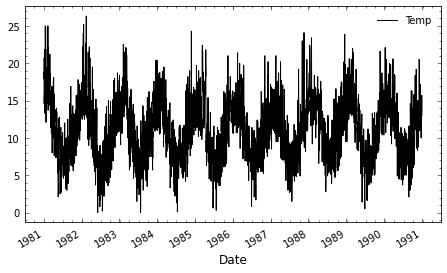

In [ ]:
df[['Temp']].plot()
plt.show()

A série acima é um bom exemplo de um conjunto de dados históricos onde é difícil através apenas do gráfico identificar se existe tendência, apesar da sazonalidade evidente, assim como o período da série. Ainda assim, é importante mantermos no nosso repertório um conjunto de testes estatísticos que nos auxiliam a verificar as condições necessárias para o modelo. 

Neste tipo de caso procedemos com uma sequência de análises necessárias para a aplicação do modelo SARIMA através das seguintes etapas:

* Verificar a estacionariedade: usamos o teste de Dickey Fuller aumentado.
* Verificar sazonalidade: Usamos o plot da ACF e PACF assim como a decomposição entre tendência, erro e sazonalidade.
* Definir os parâmetros (p,d,q)(P,D,Q,m): usaremos a biblioteca pmdarima para varrer o espaço de parâmetros.
* Fazer a previsão de valores futuros: ajustamos o modelo com o melhor conjunto de parâmetros encontrados no passo anterior e na sequência fazemos a predição para o intervalo de tempo desejado.

A seguir executaremos cada uma das etapas mencionadas utilizando o código Python.

### Teste de estacionariedade
De modo a simplificar a nossa análise vamos transformar o teste aumentado de Dickey Fuller (adf_test) em uma função Python de modo a poder chamá-la diversas vezes. O código abaixo define a função desejada:

In [ ]:
from statsmodels.tsa.stattools import adfuller

#Definição da função
def adf_test(timeseries):
    # Realiza o teste de Dickey-Fuller
    print('Resultados do Testes de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Definida a função podemos utilizá-la para testar a série visualizada no gráfico acima. 

In [ ]:
adf_test(df)

Resultados do Testes de Dickey-Fuller:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


Os resultados acima podem ser interpretado como estacionariedade para a série considerada, uma vez que o p-valor (**p-value**) é menor que 0,05.Dessa forma, podemos proceder para o próximo passo que é verificar a sazonalidade a partir da decomposição e dos gráficos de PACF e ACF uma vez que não foi necessário diferenciar a série. 

No entanto, a grande quantidade de dados para a série histórica representa diciculdades para o ajuste automático de modelos ARIMA. Note por exemplo, que nesse caso, teremos 365 valores para cada ano, ao longo de 10 anos. Dessa forma, o que podemos fazer é uma reamostragem da série considerando valores médios para o mês. No geral não se espera que isso afete a estrutura da série, como veremos a seguir. Para fazer a reamostragem utilizamos o comando **resample** já discutido nas seções anteriores. 

In [ ]:
df = df['Temp'].resample('MS').mean()

In [ ]:
df

Date
1981-01-01    17.712903
1981-02-01    17.678571
1981-03-01    13.500000
1981-04-01    12.356667
1981-05-01     9.490323
                ...    
1990-08-01     7.825806
1990-09-01     9.166667
1990-10-01    11.345161
1990-11-01    12.656667
1990-12-01    14.367742
Freq: MS, Name: Temp, Length: 120, dtype: float64

Note agora que os índices correspondem a datas de início de cada mês. Graficando a nova série temos que:  

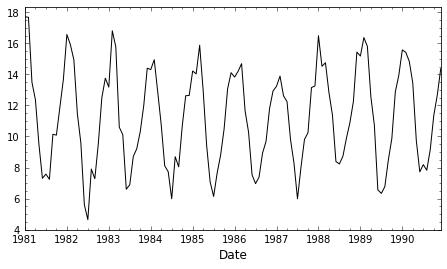

In [ ]:
df.plot();

Como procedemos com uma reamostragem, obtemos uma série nova que pode inserir componentes diferentes da série anterior. Sendo assim, é prudente realizar novamente o teste de Dickey Fuller de modo a verificar a estacionariedade. Verificando novamente o teste de Dickey Fuller para estacionariedade da série reamostrada, temos que:

In [ ]:
adf_test(df)

Resultados do Testes de Dickey-Fuller:
Test Statistic                  -1.892313
p-value                          0.335686
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


o que evidencia que a série reamostrada é não estacionária. Dessa forma podemos utilizar a estratégia de subtrair a série com o lag anterior de modo a verificar se isso satisfaz a condição de estacionariedade, nos permitindo inclusive concluir sobre o parâmetro "d" do modelo SARIMAX. Para tanto basta procedermos do seguinte modo: 

In [ ]:
#o dropna() serve para eliminar o primeiro valor da série que passa a ser nulo.
df_diff = df.diff().dropna()

In [ ]:
df_diff

Date
1981-02-01   -0.034332
1981-03-01   -4.178571
1981-04-01   -1.143333
1981-05-01   -2.866344
1981-06-01   -2.183656
                ...   
1990-08-01   -0.358065
1990-09-01    1.340860
1990-10-01    2.178495
1990-11-01    1.311505
1990-12-01    1.711075
Freq: MS, Name: Temp, Length: 119, dtype: float64

Realizando agora sim o teste de Dickey Fuller para a série diferenciada, percebemos que ela se torna etacionária com apenas uma única subtração.

In [ ]:
adf_test(df_diff)

Resultados do Testes de Dickey-Fuller:
Test Statistic                  -4.629576
p-value                          0.000114
#Lags Used                      12.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


Observe agora que o resultado do p-valor é muito menor do que 0.05.

### Estudo da Sazonalidade
A decomposição  da série em erro,tendência e sazonalidade tem a capacidade de explicitar a ocorrência de sazonalidade. O código abaixo realiza essa decomposição através do comando **seasonal_decompose**.  

<Figure size 1152x360 with 0 Axes>

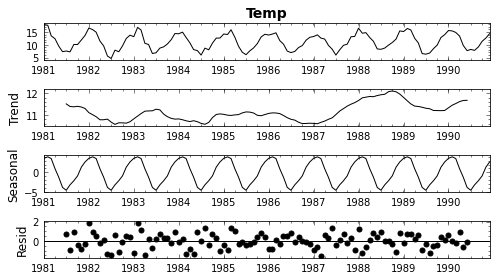

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 5)
result = seasonal_decompose(df)
result.plot();

A partir do resultado acima, podemos verificar a existência clara de sazonalidade, através da repetição anual no terceiro gráfico (Seasonal), uma vez que temos intervalos repetidos. Como a unidade do dado da série é mensal(lembre-se que reamostramos a série) sabemos que o parâmetro de sazonalidade será m=12 para a série. Na sequência, podemos verificar também o gráfico da ACF e da PACF de modo a verificar o comportamento auto-regressivo da série. Os comando abaixo mostram os gráficos das duas funções respectivamente:

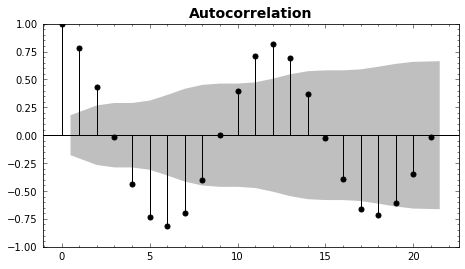

In [ ]:
# ACF
from statsmodels.graphics.tsaplots import plot_acf
x=plot_acf(df)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


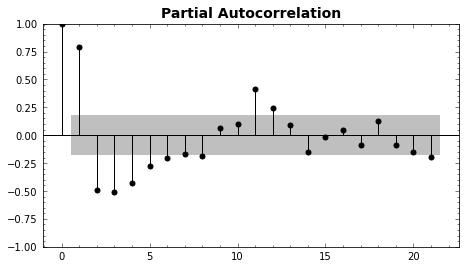

In [ ]:
x=plot_pacf(df);

Observando o gráfico da PACF, é evidente que após o lag 3 não podemos afirmar que os coeficientes da autocorrelação parcial não são diferentes de zero. O que nos permite determinar a ordem da componente de autoregressiva. No entanto, vamos neste contexto, utilizar o comando **auto_arima** para varrer um determinado espaço de parâmetros. O comando **auto_arima** nos permite escolher o melhor conjunto de parâmetros a partir do AIC.

### Ajustando um modelo SARIMA automaticamente
A biblioteca **pmdarima** foi construída em Python de modo a implementar o comando **auto.arima** da linguagem **R**. Esse comando  irá nos ajudar a varrer o espaço de parâmetros e encontrar os valores (p,d,q)$\times$(P,D,Q)(m). De um modo geral, o comando tenta proceder a uma espécie de **grid search** experimentando vários valores de **p** e **q** (assim como das componentes sazonais **P** e **Q**), e definindo o melhor modelo a partir do menor valor do AIC (também é possível escolher a partir do BIC ou outro critério).

O uso do **auto-arima** é bastante simples, como pode ser visto a seguir:

In [ ]:
auto_arima(df,
           seasonal=True,
           max_p=3,max_q=3,max_P=3,max_Q=3,d=1,D=1,m=12,
           trace=True,
           stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=332.768, Time=2.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=419.786, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=354.201, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=327.579, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=365.249, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=329.563, Time=1.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=329.565, Time=1.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=341.144, Time=0.37 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=4.20 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=329.340, Time=0.69 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=329.432, Time=0.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=339.699, Time=0.30 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=32

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -160.790
Date:                            Sat, 14 Jan 2023   AIC                            327.579
Time:                                    00:44:35   BIC                            335.598
Sample:                                01-01-1981   HQIC                           330.830
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7856      0.073    -10.697      0.000      -0.930      -0.642
ma.S.L12      -0.8014      0.121     -6.602      0.000      -1.039      -0.564
sigma2         1.0448      0.179      5.834      0.000       0.694       1.396
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.92   Prob(JB):                         0.78
Heteroskedasticity (H):               0.51   Skew:                             0.09
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note que como parâmetros para a execução da função **auto_arima** passamos as opções seasonal=True, de modo que ele considere a possibilidade de uma série com sazonalidade e indicamos os valores máximos de p,q,P,Q, assim como os valores de **d=1** e **D=1**. O principal motivo para essa escolha é que no geral o comando parte do pressuposto que a série em questão é estacionária e no nosso caso em particular verificamos através do teste de Dickey Fuller que a série só se tornava estacionária a partir de uma diferenciação. 

O parâmetro Trace=True permite que ao longo da execução possamos visualizar o conjunto de parâmetros testados e a opção stepwise utiliza um algoritmo interno da biblioteca que otimiza as buscas de parâmetros. Você pode encontrar mais detalhes dessas opções de parâmetros para o comando auto_arima no [link](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA). 

A partir do momento que temos uma boa escolha para os parâmetros **(p,d,q)x(P,D,Q)(m)**, podemos recorrer novamente à biblioteca **statsmodel**, de modo a ajustar o modelo, fazer a previsão para uma parte da série e assim avaliar através de alguma métrica, como MAE, ou RMSE, a qualidade do ajuste. 

Em seguida, utilizamos a função SARIMAX da biblioteca **statsmodel** para passar os parâmetros do modelo e procedemos com o ajuste. 

In [ ]:
#import do comando SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

#declaração do modelo
model = SARIMAX(df,order=(0,1,1),seasonal_order=(0,1,1,12),enforce_invertibility=False)
#ajuste do modelo
results = model.fit()
#resultados e métricas de avaliação
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Temp   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -160.790
Date:                            Sat, 14 Jan 2023   AIC                            327.579
Time:                                    00:44:35   BIC                            335.598
Sample:                                01-01-1981   HQIC                           330.830
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7856      0.073    -10.697      0.000      -0.930      -0.642
ma.S.L12      -0.8014      0.121     -6.602      0.000      -1.039      -0.564
sigma2         1.0448      0.179      5.834      0.000       0.694       1.396
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.92   Prob(JB):                         0.78
Heteroskedasticity (H):               0.51   Skew:                             0.09
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Comentar os resultados dos testes aqui e como interpretar. Principalmente os coeficientes e talvez o teste de Ljung_Box para os resíduos????? P-value também.


Uma outra forma importante de avaliação e recomendada sempre que ajustamos um modelo ARIMA (ou SARIMAX), é através do comando **plot_diagnostics**. Esta função nos permite avaliar se as premissas do modelo não foram violadas.  

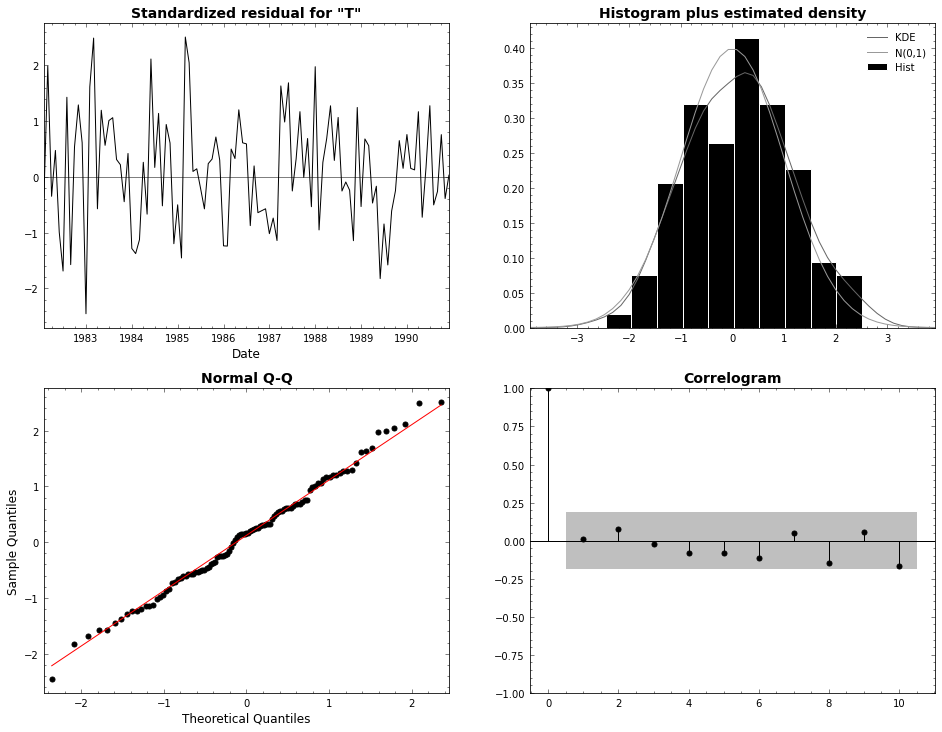

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

As verificações importantes neste caso são as de que os resíduos parecem seguir uma distribuição normal (indicando aleatoriedade) como pode ser visto através do histograma e do gráfico Q-Q.

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=False)

Podemos ainda, obter um dataframe com o intervalo de confiança para os valores preditos através do comando **conf_int()** a seguir:

In [ ]:
pred_ci = pred.conf_int()
pred_ci

,lower Temp,upper Temp
Date,,
1990-01-01,12.785637,16.809403
1990-02-01,13.250202,17.272649
1990-03-01,12.695660,16.717297
1990-04-01,10.223438,14.244575
1990-05-01,8.479905,12.500733
1990-06-01,5.533833,9.554471
1990-07-01,4.864613,8.885133
1990-08-01,6.330115,10.350563
1990-09-01,7.423555,11.443959


Podemos assim visualizar a série histórica, acrescentando o valor predito para o ano de 1990. 

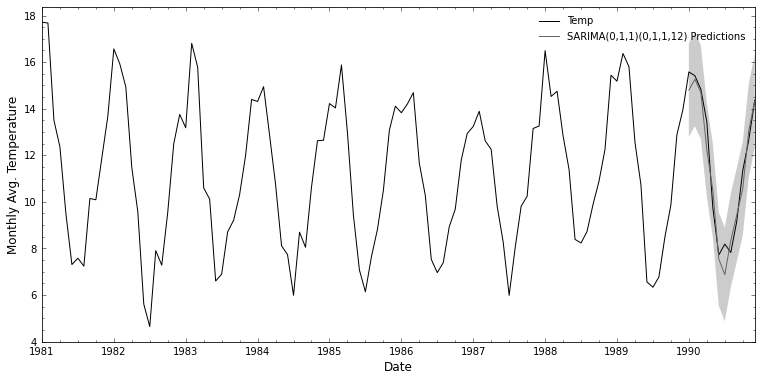

In [ ]:
ylabel='Monthly Avg. Temperature'
xlabel='Date'

ax = df.plot(legend=True,figsize=(12,6))
pred.predicted_mean.rename('SARIMA(0,1,1)(0,1,1,12) Predictions').plot(legend=True, )

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Apesar do ajuste parecer relativamente bom a partir da visualização do gráfico, é importante estimar o erro quadrático médio (MSE), assim como a sua raiz (RMSE):

In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(pred.predicted_mean,df['1990-01-01':])
RMSE = np.sqrt(MSE)
print("RMSE = {:0.2f}".format(RMSE))

RMSE = 0.68


Observe no entanto que o RMSE está na mesma unidade da série, ele pode ser interpretado no caso como flutuações de temperatura. No gráfico acima a escala de temperatura parece variar no intervalo de 5 a 18 unidades. A flutuação de 0.68 é em torno de 4% dessa escala onde a temperatura varia, garantindo que o RMSE seja muito menor (~4%) do que a variação do dado, o que é um excelente resultado.

### Realizando a previsão

Realizado todos os procedimentos acima, fazer a previsão de valores futuros que não estão na amostra (**forecast** em inglês), é trivial. A biblioteca statsmodel mantém a função **get_forecast** que recebe como argumento o número de pontos através do parâmetro **steps**. Nesse caso, para fazermos a previsão para os próximos 50 pontos futuros da série estudada, basta fazermos:

In [ ]:
pred_uc = results.get_forecast(steps=50)

# Intervalo de Confiança
pred_ci = pred_uc.conf_int()

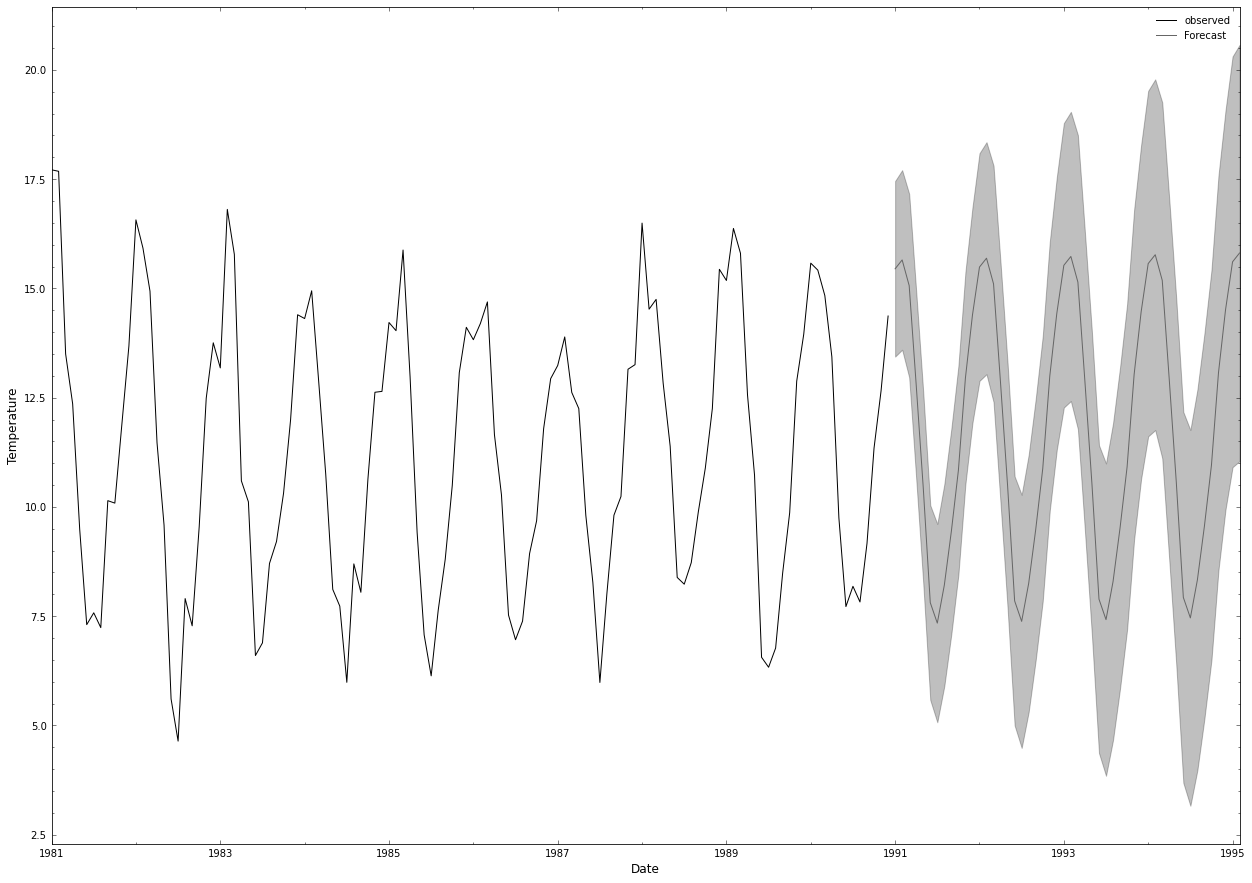

In [ ]:
ax = df.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')

plt.legend()
plt.show()

## Modelos SARIMAX

Na seção anterior discutimos modelos SARIMA como uma extensão dos modelos ARIMA de modo a contabilizar o efeito da sazonalidade. No entanto, outras generalizações ainda são viáveis como a possibilidade de levar em consideração variáveis explicativas auxiliares para o modelo. Neste contexto surgem os modelos denominados SARIMAX onde o **X** se refere a modelos ARIMA sazonais com variáveis denominadas e**X**ógenas. 

Variáveis exógenas em séries temporais são variáveis externas ou explicativas que podem servir como inputs adicionais de modo a prever ou entender variações nos sistemas estudados. Exemplos de variáveis exógenas são:
* Indicadores econômicos: o produto interno bruto (PIB), taxas de desemprego, inflação etc, podem ser considerados como variáveis exógenas em séries de mofdelagem econômica.
* Variáveis climáticas: temperatura, precipitação, umidade relativa do ar podem ser variáveis exógenas em séries que se propõe a modelar por exemplo a produção de energia em um país de matriz energética como a do Brasil. 
* Variáveis de datas e feriados: feriados costumam impactar positivamente e negativamente a quantidade de vendas e participação de eventos. 

Estes são apenas alguns exemplos de variáveis que podem ser consideradas exógenas mas o seu uso requer na maioria das vezes um conhecimento significativo do negócio, de modo a estabelecer uma hipóteses sobre a influência dessa variável na série a ser modelada. 

A modelagem de modelos SARIMAX  utilizando variáveis exógenas é muito similar a modelagem de modelos SARIMA. Nas próximas seções iremos discutir essa modelagem através de exemplos práticos em Python. 

### SARIMAX com Python (hands-on)

Vamos comear agora lendo um novo conjunto de dados. Estes dados consistem em índices de consumo, renda, produção, economias e desemprego para a população americana. 

In [ ]:
df = pd.read_csv('uschange.csv',parse_dates=True)
df.head()

,Date,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.615986,0.972261,-2.452700,4.810312,0.9
1,1970 Q2,0.460376,1.169085,-0.551525,7.287992,0.5
2,1970 Q3,0.876791,1.553271,-0.358708,7.289013,0.5
3,1970 Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1971 Q1,1.897371,1.987154,1.909734,3.657771,-0.1


Observe que neste caso a coluna **Date** precisa ser transformada para o formato datetime, e também para o índice do dataframe. No entanto a tranformação em datetime neste caso se torna ligeiramente mais complexa, onde precisamos separar a informação do quarter (Q1,Q2,Q3,Q4) do ano em questão e colocar um hífen entre as duas informações para que a instrução datetime possa executar. Isso feito, podemos converter a coluna **Date** para o índice do dataframe.

In [ ]:
df['date'] = pd.to_datetime( df['Date'].str[:4] + "-"+ df['Date'].str[-2:])

In [ ]:
df = df.set_index("date")

In [ ]:
df

,Date,Consumption,Income,Production,Savings,Unemployment
date,,,,,,
1970-01-01,1970 Q1,0.615986,0.972261,-2.452700,4.810312,0.9
1970-04-01,1970 Q2,0.460376,1.169085,-0.551525,7.287992,0.5
1970-07-01,1970 Q3,0.876791,1.553271,-0.358708,7.289013,0.5
1970-10-01,1970 Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7
1971-01-01,1971 Q1,1.897371,1.987154,1.909734,3.657771,-0.1
...,...,...,...,...,...,...
2015-07-01,2015 Q3,0.664970,0.801663,0.380606,3.180930,-0.3
2015-10-01,2015 Q4,0.561680,0.740063,-0.845546,3.482786,0.0
2016-01-01,2016 Q1,0.404682,0.519025,-0.417930,2.236534,0.0


Observe que agora todas as colunas são indexadas e podem ser acessadas pela data de início de cada trimestre.

Para estudarmos o comportamento das variáveis exógenas podemos iniciar verificando se a variável exógena renda (Income), pode auxiliar no ajuste da variável endógena consumo (Consumption). Para facilitar vamos nos referir aos nomes originais das colunas em inglês.

O gráfico nos permite visualizar o comportamento histórico destas duas séries.

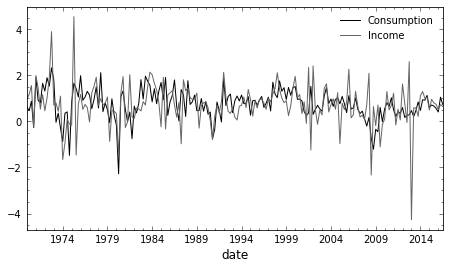

In [ ]:
df[['Consumption','Income']].plot()
plt.show()

Seguindo os mesmos procedimentos de análise da seção anterior, podemos utilizar o teste de Dickey Fuller para observar que as duas séries possuem tendência.

In [ ]:
adf_test(df['Consumption'])

Resultados do Testes de Dickey-Fuller:
Test Statistic                  -4.522487
p-value                          0.000179
#Lags Used                       2.000000
Number of Observations Used    184.000000
Critical Value (1%)             -3.466398
Critical Value (5%)             -2.877380
Critical Value (10%)            -2.575214
dtype: float64


In [ ]:
adf_test(df['Income'])

Resultados do Testes de Dickey-Fuller:
Test Statistic                -1.515469e+01
p-value                        6.720576e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


Observando os **p-value** para o resultado dos dois testes, podemos concluir que as duas séries são estacionárias, o que pode ser verificado também a partir da decomposição erro, tendência e sazonalidade:

<Figure size 1152x360 with 0 Axes>

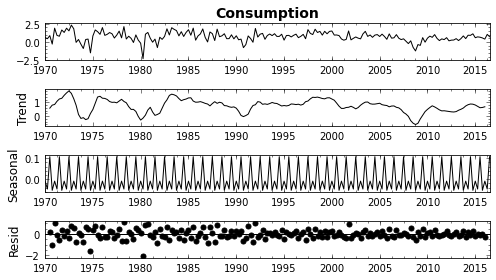

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 5)
result = seasonal_decompose(df['Consumption'])
result.plot();

<Figure size 1152x360 with 0 Axes>

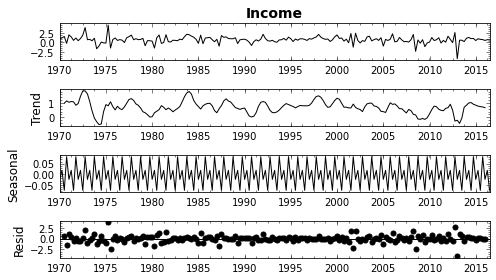

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 5)
result = seasonal_decompose(df['Income'])
result.plot();

Logo como podemos verificar acima as duas séries são estacionárias. 

Dado essa estacionariedade utilizaremos a função auto_arima para varrer o espaço de parâmetros e encontrar os valores (p,d,q) × (P,D,Q)(m), para a série Consumption, em princípio sem contabilizar o efeito de qualquer variável exógena. Assim, poderemos comparar a série ajustada sem e com variáveis explicativas.

In [ ]:
auto_arima(df['Consumption'],seasonal=True,m=4, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=343.154, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=375.632, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=355.235, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=361.078, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=529.744, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=342.517, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=342.284, Time=0.22 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=343.093, Time=0.47 sec
 ARIMA(1,0,2)(0,0,0)[4] intercept   : AIC=343.330, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=344.493, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[4] intercept   : AIC=342.536, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[4] intercept   : AIC=343.179, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=343.815, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[4] intercept   : AIC=341.613, Time=0.13 sec
 ARIMA(1,0,3)(1,0,0)[4] intercept   : AIC=343.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -164.807
Date:                Sat, 14 Jan 2023   AIC                            341.613
Time:                        00:44:50   BIC                            361.000
Sample:                    01-01-1970   HQIC                           349.469
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3066      0.096      3.199      0.001       0.119       0.494
ar.L1          0.5887      0.132      4.458      0.000       0.330       0.847
ma.L1         -0.3529      0.138     -2.552      0.011      -0.624      -0.082
ma.L2          0.0846      0.065      1.309      0.190      -0.042       0.211
ma.L3          0.1738      0.079      2.214      0.027       0.020       0.328
sigma2         0.3405      0.025     13.646      0.000       0.292       0.389
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                64.65
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dessa forma, obtemos que os parâmetros (1,0,3)x(0,0,0,4) constituem de acordo com o critério de Akaike (AIC) o conjunto mais apropriado para a série estudada.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['Consumption'],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -174.305
Date:                Sat, 14 Jan 2023   AIC                            358.611
Time:                        00:44:50   BIC                            374.766
Sample:                    01-01-1970   HQIC                           365.157
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9348      0.037     25.477      0.000       0.863       1.007
ma.L1         -0.6069      0.059    -10.370      0.000      -0.722      -0.492
ma.L2          0.0526      0.062      0.850      0.395      -0.069       0.174
ma.L3          0.0723      0.069      1.048      0.295      -0.063       0.208
sigma2         0.3752      0.029     12.936      0.000       0.318       0.432
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                30.74
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A partir do objeto **results** criado acima, podemos predizer os valores para uma determinado intervalo de tempo e medir a qualidade do ajuste através de métricas como o MSE, RMSE ou qualquer outra mais conveniente.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['Consumption'],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -174.305
Date:                Sat, 14 Jan 2023   AIC                            358.611
Time:                        00:44:50   BIC                            374.766
Sample:                    01-01-1970   HQIC                           365.157
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9348      0.037     25.477      0.000       0.863       1.007
ma.L1         -0.6069      0.059    -10.370      0.000      -0.722      -0.492
ma.L2          0.0526      0.062      0.850      0.395      -0.069       0.174
ma.L3          0.0723      0.069      1.048      0.295      -0.063       0.208
sigma2         0.3752      0.029     12.936      0.000       0.318       0.432
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                30.74
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2012-Q3'), dynamic=False)

In [ ]:
pred_ci = pred.conf_int()

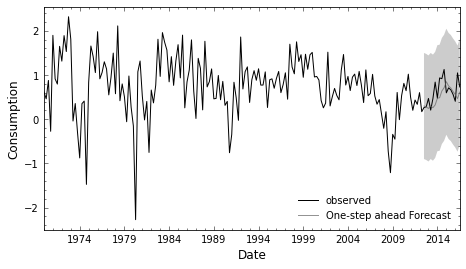

In [ ]:
ax = df['Consumption'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.legend()

plt.show()

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse
reals = df['2012-Q3':]['Consumption']
error1 = mse(pred.predicted_mean, reals)
error2 = rmse(pred.predicted_mean, reals)

print(f'SARIMA(1,0,3)(0,0,0,4) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) RMSE Error: {error2:11.10}')

SARIMA(1,0,3)(0,0,0,4) MSE Error: 0.07455724995
SARIMA(1,0,3)(0,0,0,4) RMSE Error: 0.2730517349


### Adicionando a variável exógena ao modelo SARIMA

Na seção anterior, se você observou utilizamos o comando SARIMAX para fazer o ajuste (**.fit**) do modelo, apesar de não termos especificado qual variável usaríamos. Dentro do contexto da biblioteca statsmodel, adicionar a variável exógena é bastante simples, bastando adicionar **exog=df[[variável1,variável2,...]]** como parâmetro do comando. Desta forma, vamos aproveitar o resultado da seção anterior acrescentando primeiro a coluna **Income** e depois as demais colunas em conjunto. 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


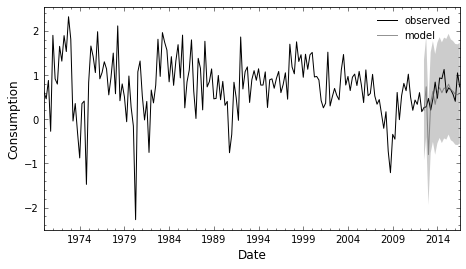

In [ ]:
model = SARIMAX(df['Consumption'],exog=df[['Income']],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

pred = results.get_prediction(start=pd.to_datetime('2012-Q3'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['Consumption'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='model', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.legend()

plt.show();

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse
reals = df['2012-Q3':]['Consumption']
error1 = mse(pred.predicted_mean, reals)
error2 = rmse(pred.predicted_mean, reals)

print(f'SARIMA(1,0,3)(0,0,0,4) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) RMSE Error: {error2:11.10}')

SARIMA(1,0,3)(0,0,0,4) MSE Error: 0.1636153323
SARIMA(1,0,3)(0,0,0,4) RMSE Error: 0.4044939212


Observe que acrescentar uma única variável no sistema, não necessariamente implica em um ajuste melhor. No nosso exemplo o RMSE por exemplo varia de 0.27 para 0.40 no caso de incluirmos a variável Income. Vale destacar que nesse caso não nos preocupamos em utilizar nenhum método de seleção de variáveis, dado que estaria além do escopo a que nos propomos aqui, e apenas acrescentamos arbitrariamente os valores de uma nova coluna.

A título de curiosidade vamos acrescentar as demais colunas (Income, Production, Savings,Unemployment) e verificar através da mesma métrica, a qualidade do ajuste:

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


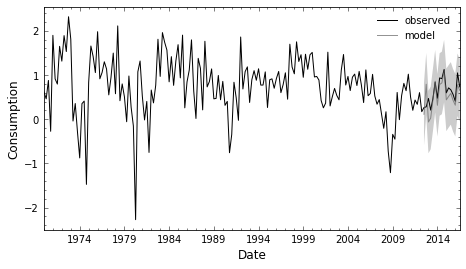

In [ ]:
model = SARIMAX(df['Consumption'],exog=df[['Income','Production','Savings','Unemployment']],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

pred = results.get_prediction(start=pd.to_datetime('2012-Q3'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['Consumption'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='model', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.legend()

plt.show();

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse
reals = df['2012-Q3':]['Consumption']
error1 = mse(pred.predicted_mean, reals)
error2 = rmse(pred.predicted_mean, reals)

print(f'SARIMA(1,0,3)(0,0,0,4) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) RMSE Error: {error2:11.10}')

SARIMA(1,0,3)(0,0,0,4) MSE Error: 0.04910865589
SARIMA(1,0,3)(0,0,0,4) RMSE Error: 0.2216047289


Observe que agora obtivemos para a mesma métrica, o RMSE, um valor ainda melhor. Esse exercício nos permite assim concluir que não existe uma receita simples e definitva para melhorar a qualidade do ajuste, como simplesmente adicionar variáveis exógenas adicionais. A utilização de modelos SARIMAX requer uma análise exploratória detalhada dos dados, assim como a experimentação de diversos valores de parâmetros de modo a escolher o valor mais apropriado para o ajuste. 

Uma outra limitação dos modelos SARIMAX pode ser melhor entendida se tentamos fazer o forecast para os próximos 15 pontos no gráfico:

In [ ]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=15)

ValueError: ignored

Note que a mensagem **ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument** é de certa forma auto-explicativa. Como não temos o intervalo futuro (próximos 15 pontos) para as variáveis exógenas (Income, Production, Savings,Unemployment), nós não conseguimos fazer o forecast desejado. Caso tivéssemos precisaríamos passar este parâmetro como argumento da função **get_forecast** como no seguinte exemplo: 


```
pred_uc = results.get_forecast(steps=15, exog= df_exog)
```
onde **df_exog** precisaria ser um dataframe com 4 colunas (Income, Production, Savings,Unemployment) e 15 linhas (próximos 15 pontos do gráfico).

Um exemplo muito comum para o uso deste tipo de modelagem é por exemplo quando queremos fazer um forecast para prever vendas ao longo das próximas duas semanas. Neste caso poderíamos utilizar como variável exógena se um determinado dia da semana é feriado ou não. Nesse caso seria relativamente fácil obter o dataframe **df_exog** com uma coluna de valores 0 ou 1 no caso do dia ser feriado sim ou não respectivamente. De fato, esse é um procedimento relativamente comum e existe inclusive uma biblioteca em python que calcula os feriados denominada **holiday**. Você pode obter mais detalhes acessando [aqui](https://pypi.org/project/holidays/).
